In [4324]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import pickle, random
from tqdm import tqdm
from scipy.spatial import KDTree

In [4325]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

In [4326]:
#df0 = pd.read_csv('../spreadsheets/rlhf_1064.csv') # 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_159nlp.csv') # second Best 0.01, 0.85, 0.01, 0.95, 0.95, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_small_07rl.csv') # Best
#df0 = pd.read_csv('../spreadsheets/rlhf_large_1072.csv')
#df0 = pd.read_csv('../spreadsheets/shufled_rlhf_11rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_12rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_15rl.csv')
df0 = pd.read_csv('../spreadsheets/rlhf_small_154nlp.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_19rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_24rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_23rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_25rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_26rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_157nlp.csv') # 0.7, 0.95, 0.5, 0.999, 0.99, 16000
#df0 = pd.read_csv('../spreadsheets/rlhf_small_157nlpgate.csv') # 0.25, 0.95, 0.01, 0.997, 0.999, 14000
#df0 = pd.read_csv('../spreadsheets/rlhf_small_29rl.csv') # 0.9, 0.9, 0.005, 0.95, 0.999, 10000,
#df0 = pd.read_csv('../spreadsheets/rlhf_small_30rl.csv') # 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_small_32rl.csv') # 0.01, 0.85, 0.01, 0.95, 0.95, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_small_33rl.csv')# 0.05, 0.85, 0.01, 0.997, 0.95, 4000
# df0 = pd.read_csv('../spreadsheets/rlhf_small_36rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_39rl.csv')# 0.05, 0.85, 0.01, 0.997, 0.95, 4000
#df0 = pd.read_csv('../spreadsheets/rlhf_small_154nlp_refined.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_27rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_43rl.csv') # 0.001, 0.99, 1.0, 0.95, 0.99, 10000
#df0 = pd.read_csv('../spreadsheets/rlhf_1064_2.csv')

In [4327]:
#!pip show numpy

In [4328]:
#df0['action'] = df0['action'].replace('go_long', 'do_nothing')

In [4329]:
df0.head()

,Unnamed: 0,sma-05 (entry),sma-07 (entry),sma-25 (entry),sma-compare (entry),is_short,action,imit-action,nlpreds,reward
0,0,26.51860,26.494286,26.480640,0,0,go_long,go_short,go_long,12.655161
1,1,5.47140,5.535714,5.552160,1,0,go_long,go_short,go_long,38.210539
2,2,0.12230,0.122729,0.125424,1,1,go_short,go_short,go_long,-5.774026
3,3,2.29758,2.302243,2.299924,0,1,go_short,go_short,go_short,-2.632130
4,4,43.28800,43.291429,42.727200,0,0,go_long,go_short,go_short,38.482866


In [4330]:
df0['nlpreds'].value_counts()

nlpreds
go_short    641
go_long     450
Name: count, dtype: int64

In [4331]:
#df0['refined-action'].value_counts()

In [4332]:
df0['action'].value_counts()

action
go_short    651
go_long     440
Name: count, dtype: int64

In [4333]:
def prep_data(df: DataFrame) -> DataFrame:
    train_data = pd.DataFrame()
    for col in df.columns:
        col_name = col.split(' ')[0]
        train_data[f'{col_name}'] = df[col]

    return train_data

In [4334]:
#newdf0 = pd.DataFrame()
train_data = prep_data(df0) if newdf0.empty else prep_data(newdf0)
#train_data = prep_data(newdf0)

In [4335]:
train_data.head(2)

,ask,bid,sma-05,sma-07,sma-25,sma-compare,is_short,action,nlpreds,predicted_action,reward,refined-action
0,2.018487e+04,2.024511e+04,26.5186,26.494286,26.48064,0,0,go_long,do_nothing,do_nothing,12.655161,go_long
1,1.410609e+06,1.440998e+06,5.4714,5.535714,5.55216,1,0,go_long,go_short,go_short,38.210539,go_long


In [4336]:
# Encode actions into numerical values
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}
action_col = 'nlpreds' if newdf0.empty else 'refined-action'
train_data["action_num"] = train_data[f"{action_col}"].map(action_mapping)

In [4337]:
#train_data["action_num"].tail()

In [4338]:
# Define RL parameters
states = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values  # Include binary_state
actions = list(action_mapping.values())  # Action space
rewards = train_data["reward"].values  # Rewards
n_states = states.shape[0]
n_actions = len(actions)

In [4339]:
# Initialize Q-table
q_table = np.zeros((n_states, n_actions))

In [4340]:
list_1 = [
    [0.25, 0.95, 1.0, 0.99, 0.99, 10000],
]

list_2 = [
    [0.25, 0.95, 1.0, 0.99, 0.99, 10000],
]

# Combine the lists and remove duplicates
combined_set = {tuple(sublist) for sublist in list_1 + list_2}

# Convert the set back to a list of lists
combined_list = [list(sublist) for sublist in combined_set]

# Print the combined list
for sublist in combined_list:
    print(sublist)

[0.25, 0.95, 1.0, 0.99, 0.99, 10000]


In [4341]:
Hyperparameters = [
    [0.001, 0.99, 1.0, 0.95, 0.99, 10000],
    [1, 0.9, 1.0, 0.99, 0.99, 11000],
    [0.1, 0.9, 0.1, 0.99, 0.995, 4000],
    [0.005, 0.75, 0.1, 0.95, 0.999, 12000],
    [0.001, 0.75, 1.0, 0.99, 0.99, 30000],
    [1, 0.75, 0.005, 0.95, 0.95, 22000],
    [0.01, 0.99, 1.0, 0.95, 0.99, 16000],
    [0.7, 0.99, 1.0, 0.95, 0.997, 8000],
    [0.01, 0.95, 1.0, 0.997, 0.995, 26000],
    [0.25, 0.95, 0.01, 0.997, 0.999, 14000],
    [0.5, 0.85, 0.5, 0.997, 0.997, 14000],
    [0.01, 0.85, 0.01, 0.95, 0.95, 12000],
    [0.9, 0.99, 0.5, 0.995, 0.95, 12000],
    [0.05, 0.9, 0.5, 0.95, 0.999, 4000],
    [0.05, 0.99, 0.5, 0.99, 0.997, 6000],
    [1, 0.75, 0.05, 0.999, 0.999, 10000],
    [0.9, 0.95, 1.0, 0.99, 0.99, 8000],
    [0.25, 0.75, 0.01, 0.995, 0.999, 20000],
    [0.3, 0.75, 1.0, 0.995, 0.99, 10000],
    [1, 0.9, 1.0, 0.999, 0.999, 10000],
    [0.7, 0.75, 1.0, 0.97, 0.999, 28000],
    [0.05, 0.95, 1.0, 0.999, 0.995, 12000],
    [0.7, 0.95, 0.5, 0.999, 0.99, 16000],
    [0.25, 0.95, 1.0, 0.99, 0.99, 10000],
    [0.25, 0.99, 0.01, 0.997, 0.99, 8000],
    [1, 0.95, 0.1, 0.96, 0.96, 12000],
    [0.9, 0.9, 0.005, 0.95, 0.999, 10000],
    [0.05, 0.85, 0.01, 0.997, 0.95, 4000],
    [0.01, 0.9, 0.5, 0.999, 0.999, 1500],
    [1, 0.85, 1.0, 0.95, 0.997, 21000],
    [0.7, 0.9, 0.05, 0.95, 0.95, 20000]


]

In [4342]:
for i in enumerate(Hyperparameters):
    print(i)

(0, [0.001, 0.99, 1.0, 0.95, 0.99, 10000])
(1, [1, 0.9, 1.0, 0.99, 0.99, 11000])
(2, [0.1, 0.9, 0.1, 0.99, 0.995, 4000])
(3, [0.005, 0.75, 0.1, 0.95, 0.999, 12000])
(4, [0.001, 0.75, 1.0, 0.99, 0.99, 30000])
(5, [1, 0.75, 0.005, 0.95, 0.95, 22000])
(6, [0.01, 0.99, 1.0, 0.95, 0.99, 16000])
(7, [0.7, 0.99, 1.0, 0.95, 0.997, 8000])
(8, [0.01, 0.95, 1.0, 0.997, 0.995, 26000])
(9, [0.25, 0.95, 0.01, 0.997, 0.999, 14000])
(10, [0.5, 0.85, 0.5, 0.997, 0.997, 14000])
(11, [0.01, 0.85, 0.01, 0.95, 0.95, 12000])
(12, [0.9, 0.99, 0.5, 0.995, 0.95, 12000])
(13, [0.05, 0.9, 0.5, 0.95, 0.999, 4000])
(14, [0.05, 0.99, 0.5, 0.99, 0.997, 6000])
(15, [1, 0.75, 0.05, 0.999, 0.999, 10000])
(16, [0.9, 0.95, 1.0, 0.99, 0.99, 8000])
(17, [0.25, 0.75, 0.01, 0.995, 0.999, 20000])
(18, [0.3, 0.75, 1.0, 0.995, 0.99, 10000])
(19, [1, 0.9, 1.0, 0.999, 0.999, 10000])
(20, [0.7, 0.75, 1.0, 0.97, 0.999, 28000])
(21, [0.05, 0.95, 1.0, 0.999, 0.995, 12000])
(22, [0.7, 0.95, 0.5, 0.999, 0.99, 16000])
(23, [0.25, 0.95, 

In [4343]:
#0.3, 0.75, 1.0, 0.995, 0.99, 10000
'''
alpha = 0.7
gamma = 0.75
epsilon = 1.0
min_epsilon = 0.97
decay_rate = 0.97
n_episodes = 28000
n_states = states.shape[0]  # Number of states
n_actions = len(actions)  # Number of actions
'''
alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes = Hyperparameters[18] # Hyperparameters[30] # Hyperparameters[22] #Hyperparameters[9] # Hyperparameters[21]


In [4344]:
def create_state_index_mapping(df):
    state_to_index = {}
    for idx, row in df.iterrows():
        state = (row['sma-05'], row['sma-07'], row['sma-25'], row['sma-compare'], row['is_short'])
        state_to_index[state] = idx
    return state_to_index

# Assuming 'df' is your dataframe used during training
state_to_index = create_state_index_mapping(train_data)

# Save the state_to_index dictionary for later use
np.save('small_state_to_index.npy', state_to_index)


In [4345]:

# Helper function to choose an action using epsilon-greedy
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(q_table[state])  # Exploit: best known action


In [4346]:
# Simplified environment function
def environment_step(current_state, action):
    """
    Simulates the environment's response to an action.
    
    Args:
        current_state (int): The current state of the environment.
        action (int): The action taken by the agent.
    
    Returns:
        next_state (int): The next state after taking the action.
        reward (float): The reward received after taking the action.
    """
    # Define the environment logic here
    next_state = current_state + 1  # Example: Move to the next state
    reward = rewards[next_state]    # Example: Reward is based on the next state
    
    return next_state, reward

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Initialize a list to store rewards per episode
rewards_per_episode = []

# Training loop
for episode in tqdm(range(n_episodes), desc="evaluating results per episode ..."):
    current_state = np.random.randint(0, n_states)  # Random initial state
    total_reward = 0  # Initialize total reward for the current episode

    while current_state < n_states - 1:
        action = choose_action(current_state, epsilon)
        
        # Use the environment function to get the next state and reward
        next_state, reward = environment_step(current_state, action)

        best_next_action = np.argmax(q_table[next_state])
        q_table[current_state, action] += alpha * (
            reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
        )
        
        total_reward += reward  # Accumulate reward for the current episode
        current_state = next_state  # Move to next state

    rewards_per_episode.append(total_reward)  # Store the total reward for the current episode

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    # Optional: Log progress
    if episode % 800 == 0:  # Adjust logging frequency as needed
        print(f"Episode {episode}/{n_episodes} - Total Reward: {total_reward}, Epsilon: {epsilon}")

# Example: Save the Q-table
np.save("small_q_table.npy", q_table)

evaluating results per episode ...:   0%|          | 28/10000 [00:00<00:36, 272.32it/s]

Episode 0/10000 - Total Reward: 340.60188608000016, Epsilon: 0.995


evaluating results per episode ...:   9%|▊         | 859/10000 [00:03<00:33, 274.88it/s]

Episode 800/10000 - Total Reward: 287.13005024, Epsilon: 0.995


evaluating results per episode ...:  17%|█▋        | 1681/10000 [00:06<00:30, 270.42it/s]

Episode 1600/10000 - Total Reward: 1294.2525211700033, Epsilon: 0.995


evaluating results per episode ...:  25%|██▍       | 2465/10000 [00:08<00:27, 277.02it/s]

Episode 2400/10000 - Total Reward: 287.13005024, Epsilon: 0.995


evaluating results per episode ...:  33%|███▎      | 3272/10000 [00:11<00:25, 267.08it/s]

Episode 3200/10000 - Total Reward: 1375.9142074200038, Epsilon: 0.995


evaluating results per episode ...:  41%|████      | 4086/10000 [00:14<00:21, 269.60it/s]

Episode 4000/10000 - Total Reward: 573.6837153199994, Epsilon: 0.995


evaluating results per episode ...:  48%|████▊     | 4830/10000 [00:17<00:19, 267.71it/s]

Episode 4800/10000 - Total Reward: 776.0243170100002, Epsilon: 0.995


evaluating results per episode ...:  56%|█████▋    | 5632/10000 [00:20<00:15, 282.00it/s]

Episode 5600/10000 - Total Reward: 301.08818041, Epsilon: 0.995


evaluating results per episode ...:  64%|██████▍   | 6437/10000 [00:23<00:13, 260.90it/s]

Episode 6400/10000 - Total Reward: 576.4260187499993, Epsilon: 0.995


evaluating results per episode ...:  72%|███████▏  | 7233/10000 [00:26<00:09, 285.79it/s]

Episode 7200/10000 - Total Reward: 492.8938515699997, Epsilon: 0.995


evaluating results per episode ...:  81%|████████  | 8055/10000 [00:29<00:07, 264.55it/s]

Episode 8000/10000 - Total Reward: 1225.761570230001, Epsilon: 0.995


evaluating results per episode ...:  89%|████████▊ | 8863/10000 [00:32<00:04, 251.77it/s]

Episode 8800/10000 - Total Reward: -101.13610701999839, Epsilon: 0.995


evaluating results per episode ...:  97%|█████████▋| 9682/10000 [00:35<00:01, 287.03it/s]

Episode 9600/10000 - Total Reward: 217.25053101, Epsilon: 0.995


evaluating results per episode ...: 100%|██████████| 10000/10000 [00:36<00:00, 272.77it/s]


In [4347]:
def load_q_table(file_path):
    return np.load(file_path)

def load_state_index_mapping(file_path):
    return np.load(file_path, allow_pickle=True).item()

loaded_mapping = load_state_index_mapping(file_path="small_state_to_index.npy")
loaded_qtable = load_q_table(file_path="small_q_table.npy")

In [4348]:
def prep_state(sma_05: float, sma_07: float, sma_25: float, sma_compare: int, is_short: int):
    state = np.array([[sma_05, sma_07, sma_25, sma_compare, is_short]])
    if not np.all(np.isfinite(state)):
        state = np.nan_to_num(state, nan=0.0, posinf=0.0, neginf=0.0)
    return state



In [4349]:

def predict_action(state, q_table, state_to_index, action_mapping, default_action: str = None):
    state_tuple = tuple(state.flatten())

    state_index = state_to_index.get(state_tuple, -1)

    if not state_index == -1:
        try:
            q_values = q_table[state_index]
        except ValueError as e:
            print(e)
            #return default_action
    else:
        state_tuples = list(state_to_index.keys())
        kdtree = KDTree(state_tuples)
        distance, index = kdtree.query(state.flatten())
        nearest_state_tuple = state_tuples[index]
        new_state_index = state_to_index[nearest_state_tuple]
        q_values = loaded_qtable[new_state_index]
    
    #q_values = q_table[state_index]
    best_action_index = np.argmax(q_values)
    action = [action for action, index in action_mapping.items() if index == best_action_index][0]
    return action


In [4350]:
# Example usage:
with open("small_q_table.npy", "rb") as f:
    q_table = load_q_table("small_q_table.npy")

with open("small_state_to_index.npy", "rb") as f:
    state_to_index = load_state_index_mapping("small_state_to_index.npy")

In [4351]:
X = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values
state_1 = list(X[-1:].flatten()) # sample: [[0.87024    0.85277143 0.779504   0.         1.        ]]

state = prep_state(*state_1)
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}


In [4352]:
try:
    predicted_action = predict_action(state, q_table, state_to_index, action_mapping)
    print(f"The predicted action for the state is: {predicted_action}")
except ValueError as e:
    print(e)
    print("The state is not found in the state index mapping.")

The predicted action for the state is: go_long


In [4353]:
# Predict an entire range
for idx, row in train_data.iterrows():
    state = row[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values
    action = predict_action(state, q_table, state_to_index, action_mapping)
    train_data.loc[idx, "predicted_action"] = action

In [4354]:
train_data.head(15)

,ask,bid,sma-05,sma-07,sma-25,sma-compare,is_short,action,nlpreds,predicted_action,reward,refined-action,action_num
0,2.018487e+04,2.024511e+04,26.518600,26.494286,26.480640,0,0,go_long,do_nothing,do_nothing,12.655161,go_long,0
1,1.410609e+06,1.440998e+06,5.471400,5.535714,5.552160,1,0,go_long,go_short,go_short,38.210539,go_long,0
2,4.924476e+06,5.027070e+06,0.122300,0.122729,0.125424,1,1,go_short,go_long,go_long,-5.774026,go_long,0
3,6.770843e+05,6.686044e+05,2.297580,2.302243,2.299924,0,1,go_short,go_short,go_short,-2.632130,go_short,1
4,2.693704e+03,2.677647e+03,43.288000,43.291429,42.727200,0,0,go_long,do_nothing,do_nothing,38.482866,go_long,0
5,1.173899e+08,1.176989e+08,0.022337,0.022386,0.022462,1,1,go_short,do_nothing,do_nothing,-9.615395,do_nothing,2
6,2.153749e+05,2.155601e+05,9.232800,9.142000,8.893200,0,0,go_long,go_short,go_short,19.469700,go_long,0
7,7.710601e+04,7.726149e+04,28.524400,28.671286,28.904200,1,0,go_long,go_short,go_short,2.943566,go_long,0
8,9.247465e+04,9.264235e+04,1.383400,1.386429,1.377292,0,1,go_short,go_short,go_short,-7.042068,go_short,1
9,7.880353e+03,7.872247e+03,24.172600,24.127571,23.724920,0,0,go_long,go_short,go_short,45.194056,go_long,0


In [4355]:
train_data['predicted_action'].value_counts()

predicted_action
go_long       998
do_nothing     48
go_short       45
Name: count, dtype: int64

In [4356]:
m = train_data[(train_data['nlpreds'] == 'go_long') & (train_data['reward'] > 0)]

In [4357]:
m['is_short'].value_counts()

is_short
1    274
0    186
Name: count, dtype: int64

In [4358]:
s = df0[(df0['reward'] > 0)]
s['nlpreds'].value_counts()

nlpreds
go_short    287
go_long     194
Name: count, dtype: int64

In [4359]:
# Performance measures
# Initialize cumulative rewards
cumulative_predicted_reward = 0
cumulative_actual_reward = 0

# Iterate through states to calculate rewards
for state_index in range(n_states - 1):
    # Predicted action from Q-table
    predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
    # Actual action from the ground truth
    actual_action = train_data["action_num"].iloc[state_index]

    # Get reward for predicted action only if it matches the actual action
    if predicted_action == actual_action:
        predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
        cumulative_predicted_reward += predicted_reward

    # Get actual reward for the ground truth action
    actual_reward = rewards[state_index + 1]
    cumulative_actual_reward += actual_reward

    # Optional: Log progress
    if state_index % 100 == 0:  # Adjust logging frequency as needed
        print(f"Processed state {state_index}/{n_states - 1}")
        print(f"Current Predicted Reward: {cumulative_predicted_reward}")
        print(f"Current Actual Reward: {cumulative_actual_reward}")

# Print results
print(f"Cumulative Predicted Reward: {cumulative_predicted_reward}")
print(f"Cumulative Actual Reward: {cumulative_actual_reward}")

# Optionally calculate efficiency
efficiency = (
    ((cumulative_predicted_reward - cumulative_actual_reward) / abs(cumulative_actual_reward)) * 100
    if cumulative_actual_reward != 0
    else 0
)

print(f"Prediction Efficiency: {efficiency:.2f}%")



Processed state 0/1090
Current Predicted Reward: 0
Current Actual Reward: 38.21053879
Processed state 100/1090
Current Predicted Reward: -1497.3221488599997
Current Actual Reward: -1439.5238085599997
Processed state 200/1090
Current Predicted Reward: -951.1882966200004
Current Actual Reward: -828.56395646
Processed state 300/1090
Current Predicted Reward: -688.2267154200002
Current Actual Reward: -603.1857184999999
Processed state 400/1090
Current Predicted Reward: -596.0961439400002
Current Actual Reward: -472.609580099999
Processed state 500/1090
Current Predicted Reward: -611.8604747499995
Current Actual Reward: -552.2256943499984
Processed state 600/1090
Current Predicted Reward: -151.4634322099999
Current Actual Reward: -184.6029190499986
Processed state 700/1090
Current Predicted Reward: -184.1245605299999
Current Actual Reward: -267.82184308999854
Processed state 800/1090
Current Predicted Reward: -20.165833159999934
Current Actual Reward: -271.7322811499985
Processed state 900/

In [4360]:
# Accuracy
correct_predictions = 0
for state_index in range(n_states):
    predicted_action = np.argmax(q_table[state_index])  # Predicted action
    actual_action = train_data["action_num"].iloc[state_index]  # Actual action
    if predicted_action == actual_action:
        correct_predictions += 1

accuracy = correct_predictions / n_states
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 73.42%


In [4361]:
# Confusion matrix
y_true = train_data["action_num"]  # Actual actions
y_pred = [np.argmax(q_table[state_index]) for state_index in range(n_states)]  # Predicted actions

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[724   8   5]
 [274  37   3]
 [  0   0  40]]


In [4362]:
def action_reward(action: str, is_short: int):
    m = train_data[(train_data['predicted_action'] == f'{action}') & (train_data['is_short'] == is_short)]
    counts = m['is_short'].value_counts()
    total_reward = m['reward'].cumsum()[-1:].values[0]
    wins = len(m[m['reward'] > 0])
    losses = len(m[m['reward'] <= 0])
    return {
        'counts': counts.get(is_short),
        'total reward': total_reward,
        'winrate': f'{wins * 100 / (losses + wins):.2f}%',
        'per trade profit': m[m['reward'] > 0]['reward'].sum() / wins,
        'per trade loss': m[m['reward'] <= 0]['reward'].sum() / losses
    }

In [4363]:
dirs = [0,1]
for action in action_mapping.keys():
    for is_short in dirs:
        try:
            print(f'{action} {is_short}: {action_reward(action, is_short)}')
        except IndexError as e:
            print(e)


go_long 0: {'counts': 374, 'total reward': 1818.8337362700001, 'winrate': '49.73%', 'per trade profit': 18.950135804892472, 'per trade loss': -9.07389108212766}
go_long 1: {'counts': 624, 'total reward': -815.3684768300008, 'winrate': '43.91%', 'per trade profit': 12.268098142810219, 'per trade loss': -11.933792479885714}
go_short 0: {'counts': 33, 'total reward': -335.59366205999993, 'winrate': '24.24%', 'per trade profit': 24.723055178750002, 'per trade loss': -21.3351241396}
go_short 1: {'counts': 12, 'total reward': -25.518345150000005, 'winrate': '41.67%', 'per trade profit': 11.535935124, 'per trade loss': -11.885431538571428}
do_nothing 0: {'counts': 33, 'total reward': -463.45258031999987, 'winrate': '15.15%', 'per trade profit': 17.334968831999998, 'per trade loss': -19.64740801714286}
do_nothing 1: {'counts': 15, 'total reward': -148.14451053999997, 'winrate': '20.00%', 'per trade profit': 13.592807729999999, 'per trade loss': -15.743577810833331}


In [4364]:
print(train_data['predicted_action'].value_counts())

predicted_action
go_long       998
do_nothing     48
go_short       45
Name: count, dtype: int64


### Model correction

In [4365]:
# create corrected action
def correct_action(row):
    if row['predicted_action'] == 'go_long' and row['is_short'] == 1 and row['reward'] > 0:
        return 'go_short'
    if row['predicted_action'] == 'go_short' and row['is_short'] == 0 and row['reward'] > 0:
        return 'go_long'
    if row['predicted_action'] == 'do_nothing' and row['is_short'] == 1 and row['reward'] > 0:
        return 'go_short'
    if row['predicted_action'] == 'do_nothing' and row['is_short'] == 0 and row['reward'] > 0:
        return 'go_long'
    return row['predicted_action']

def refiner_action(version: str, data: DataFrame = None) -> DataFrame:
    data['refined-action'] = data.apply(lambda x: correct_action(x), axis=1)
    # Validation: Ensure we're fixing the 751 misclassified entries
    misclassified = data[
        (data['predicted_action'] == 'go_long') & 
        (data['refined-action'] == 'go_short')
    ]
    # Add this after applying refined-action
    
    confusion_matrix = pd.crosstab(
        data['refined-action'], 
        data['predicted_action'],  # Assuming you have ground truth column
        rownames=['refined'],
        colnames=['predicted']
    )

    print("Updated Confusion Matrix:")
    print(confusion_matrix) 
    print(f"Corrected {len(misclassified)} go_long->go_short misclassifications")
    
    filename = f'../spreadsheets/rlhf_small_{version}_refined.csv'
    data.to_csv(filename, index=False)
    return data

In [4366]:
base_dir = '/home/defi/Desktop/portfolio/projects/python/pipeline_defi/'
#new_data = pd.read_csv('../spreadsheets/rlhf_small_154nlp.csv') 
def refine_file(version: str, file) -> DataFrame:
    filename = f'{base_dir}{file}.csv'
    print(filename)
    df = pd.read_csv(filename)
    #new_data = prep_data(df0.copy()) if newdf0.empty else prep_data(newdf0.copy())
    new_data = prep_data(df)   
    print(new_data.columns)
    new_train_data = refiner_action(version=version, data=new_data)

    #new_data = df0.copy()
    print(new_train_data.columns)

    new_train_data['nlpreds'] = new_train_data['predicted_action']
    #new_data['predicted_action'] = new_train_data['predicted_action']
    return new_train_data

In [4367]:
newdf0 = refine_file('154nlp', 'lean_df_154nlp')

/home/defi/Desktop/portfolio/projects/python/pipeline_defi/lean_df_154nlp.csv
Index(['ask', 'bid', 'sma-05', 'sma-07', 'sma-25', 'sma-compare', 'is_short',
       'action', 'nlpreds', 'predicted_action', 'reward'],
      dtype='object')
Updated Confusion Matrix:
predicted   do_nothing  go_long  go_short
refined                                  
do_nothing          40        0         0
go_long              5      724         8
go_short             3      274        37
Corrected 274 go_long->go_short misclassifications
Index(['ask', 'bid', 'sma-05', 'sma-07', 'sma-25', 'sma-compare', 'is_short',
       'action', 'nlpreds', 'predicted_action', 'reward', 'refined-action'],
      dtype='object')


In [4368]:
print(newdf0['predicted_action'].value_counts())


predicted_action
go_long       998
do_nothing     48
go_short       45
Name: count, dtype: int64


In [4369]:
print(newdf0['nlpreds'].value_counts())

nlpreds
go_long       998
do_nothing     48
go_short       45
Name: count, dtype: int64


In [4370]:
newdf0.head()

,ask,bid,sma-05,sma-07,sma-25,sma-compare,is_short,action,nlpreds,predicted_action,reward,refined-action
0,2.018487e+04,2.024511e+04,26.51860,26.494286,26.480640,0,0,go_long,do_nothing,do_nothing,12.655161,go_long
1,1.410609e+06,1.440998e+06,5.47140,5.535714,5.552160,1,0,go_long,go_short,go_short,38.210539,go_long
2,4.924476e+06,5.027070e+06,0.12230,0.122729,0.125424,1,1,go_short,go_long,go_long,-5.774026,go_long
3,6.770843e+05,6.686044e+05,2.29758,2.302243,2.299924,0,1,go_short,go_short,go_short,-2.632130,go_short
4,2.693704e+03,2.677647e+03,43.28800,43.291429,42.727200,0,0,go_long,do_nothing,do_nothing,38.482866,go_long


In [4371]:
print(newdf0[(newdf0['nlpreds'] == 'go_short') & (newdf0['reward'] >  0)]['reward'].sum())

255.46411705


In [4372]:
print(train_data[(train_data['nlpreds'] == 'go_short') & (train_data['reward'] >  0)]['reward'].sum())

255.46411705


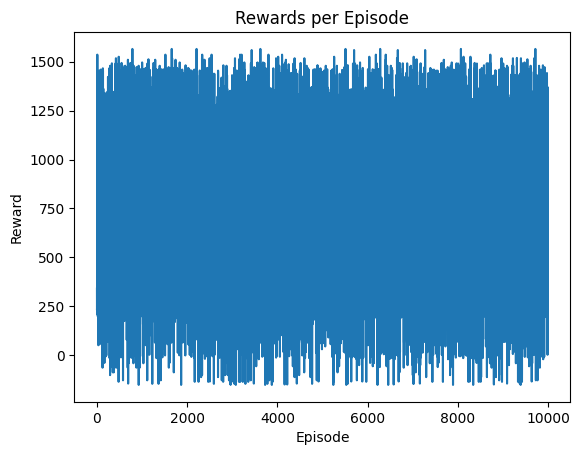

In [4373]:
import matplotlib.pyplot as plt

# Assuming you have a list of rewards for each episode
#rewards_per_episode = [...]  # Populate this with your actual data

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()


### Model tuning with Gridsearch

In [4374]:
# Tuning

def train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards):
    q_table = np.zeros((n_states, n_actions))
    rewards_per_episode = []

    for episode in range(n_episodes):
        current_state = np.random.randint(0, n_states)
        total_reward = 0

        while current_state < n_states - 1:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, n_actions)
            else:
                action = np.argmax(q_table[current_state])

            next_state = current_state + 1  # Adjust based on environment logic
            reward = rewards[next_state]

            best_next_action = np.argmax(q_table[next_state])
            q_table[current_state, action] += alpha * (
                reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
            )

            total_reward += reward
            current_state = next_state

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate)

    return q_table, rewards_per_episode


In [4375]:

def evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards):
    correct_predictions = 0
    total_reward = 0
    reward_weighted_accuracy = []

    for state_index in range(n_states):
        predicted_action = np.argmax(q_table[state_index])  # Predicted action
        actual_action = train_data["action_num"].iloc[state_index]  # Actual action
        reward = rewards[state_index]  # Reward for the action

        if predicted_action == actual_action:
            correct_predictions += 1
            total_reward += reward

        accuracy = correct_predictions / (state_index + 1)
        reward_weighted_accuracy.append(total_reward / (state_index + 1))

        # Optional: Log progress
        if state_index % 100 == 0:
            print(f"Processed state {state_index}/{n_states} - Accuracy: {accuracy * 100:.2f}%, Reward-weighted Accuracy: {reward_weighted_accuracy[-1]}")

    final_reward_weighted_accuracy = total_reward / n_states
    return final_reward_weighted_accuracy * 100



In [4376]:
def evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards):
    # Initialize cumulative rewards
    cumulative_predicted_reward = 0
    cumulative_actual_reward = 0

    # Iterate through states to calculate rewards
    for state_index in range(n_states - 1):
        # Predicted action from Q-table
        predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
        # Actual action from the ground truth
        actual_action = train_data["action_num"].iloc[state_index]

        # Get reward for predicted action only if it matches the actual action
        if predicted_action == actual_action:
            predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
            cumulative_predicted_reward += predicted_reward

        # Get actual reward for the ground truth action
        actual_reward = rewards[state_index + 1]
        cumulative_actual_reward += actual_reward
    return cumulative_predicted_reward

In [4377]:
'''
def random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_reward_weighted_accuracy = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)

        if reward_weighted_accuracy > best_reward_weighted_accuracy:
            best_reward_weighted_accuracy = reward_weighted_accuracy
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration Reward-weighted Accuracy: {reward_weighted_accuracy:.2f}%, Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

    return best_params, best_reward_weighted_accuracy

# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.96, 0.97, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 18000, 21000, 24000, 28000]
}

# Perform Random Search
best_params, best_reward_weighted_accuracy = random_search_reward_weighted(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")
'''


'\ndef random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_reward_weighted_accuracy = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)\n\n        if reward_weighted_accuracy > best_reward_weighted_accuracy:\n            best_reward_weighted_accuracy = reward_weighted_accuracy\n        

In [4378]:
'''
train_data = newdf0
def random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_cumulative_pred_reward = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)

        if cumulative_pred_reward > best_cumulative_pred_reward:
            best_cumulative_pred_reward = cumulative_pred_reward
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration cumulative predicted reward: {cumulative_pred_reward:.2f}%, Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")

    return best_params, best_cumulative_pred_reward

# Define the parameter grid
param_grid = {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000]
}

# Perform Random Search
best_params, best_cumulative_pred_reward = random_search_prediction_efficiency(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")
'''

'\ntrain_data = newdf0\ndef random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_cumulative_pred_reward = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)\n\n        if cumulative_pred_reward > best_cumulative_pred_reward:\n            best_cumulative_pred_reward = cumulative_